<a href="https://colab.research.google.com/github/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/blob/main/02_Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Partición de dataset
from sklearn.model_selection import train_test_split

# Particion de entrenamiento KFol y tunning
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, GridSearchCV

# Librerias de modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Librerias para reporte de metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score, matthews_corrcoef, make_scorer, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

# **Carga y ajustes del dataset**

In [ ]:
# Carga desde github
url = "https://raw.githubusercontent.com/JeiGeek/ia1-LosPandas-prediccion_rendimiento_estudiantil/main/Dataset/StudentPerformanceFactors.csv"
df = pd.read_csv(url)

In [ ]:
# Limpieza de nulos y valores fuera del margen
df = df.dropna()
df = df[df['Exam_Score'] <= 100]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6377 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6377 non-null   int64 
 1   Attendance                  6377 non-null   int64 
 2   Parental_Involvement        6377 non-null   object
 3   Access_to_Resources         6377 non-null   object
 4   Extracurricular_Activities  6377 non-null   object
 5   Sleep_Hours                 6377 non-null   int64 
 6   Previous_Scores             6377 non-null   int64 
 7   Motivation_Level            6377 non-null   object
 8   Internet_Access             6377 non-null   object
 9   Tutoring_Sessions           6377 non-null   int64 
 10  Family_Income               6377 non-null   object
 11  Teacher_Quality             6377 non-null   object
 12  School_Type                 6377 non-null   object
 13  Peer_Influence              6377 non-null   object
 1

In [ ]:
# Hay 13 variables de tipo categoricas, se convierten en tipo numericas (se le da un valor ya sea 0 y 1, o 1,2,3)

df_encoded = df.copy()

# Categorizacion binaria para categorias que son solo 2 dos tipos

# get_dummies - Convierte tablas categoricas en binarios
# drop_first - quita la columna redudante que se genera
df_encoded = pd.get_dummies(df_encoded, columns=["Extracurricular_Activities", "Internet_Access", "School_Type", "Learning_Disabilities", "Gender"], drop_first=True)

# Categorizacion por categorias que son de 3 tipos

# para categorias bajo - medio - alto
mapping = {"Low":1, "Medium":2, "High":3}
columnas = ["Parental_Involvement", "Access_to_Resources", "Motivation_Level", "Family_Income", "Teacher_Quality"]

for columna in columnas:
    df_encoded[columna] = df_encoded[columna].map(mapping)

# para categoria negativo - positivo - neutral
mapping = {"Negative":-1, "Positive":1, "Neutral":0}
df_encoded["Peer_Influence"] = df_encoded["Peer_Influence"].map(mapping)

# para categoria High School - College - Postgraduate
mapping = {"High School":1, "College":2, "Postgraduate":3}
df_encoded["Parental_Education_Level"] = df_encoded["Parental_Education_Level"].map(mapping)

# para categoria Near - Moderate - Far
mapping = {"Near":1, "Moderate":2, "Far":3}
df_encoded["Distance_from_Home"] = df_encoded["Distance_from_Home"].map(mapping)


# Convertir las columnas booleanas resultantes en 0 y 1
bool_cols = df_encoded.select_dtypes(include=["bool"]).columns # Se seleccionan las columnas solamente las columnas booleanas
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int) # Se convierten en 0 y 1

In [ ]:
df_encoded

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Peer_Influence,Physical_Activity,Parental_Education_Level,Distance_from_Home,Exam_Score,Extracurricular_Activities_Yes,Internet_Access_Yes,School_Type_Public,Learning_Disabilities_Yes,Gender_Male
0,23,84,1,3,7,73,1,0,1,2,1,3,1,1,67,0,1,1,0,1
1,19,64,1,2,8,59,1,2,2,2,-1,4,2,2,61,0,1,1,0,0
2,24,98,2,2,7,91,2,2,2,2,0,4,3,1,74,1,1,1,0,1
3,29,89,1,2,8,98,2,1,2,2,-1,4,1,2,71,1,1,1,0,1
4,19,92,2,2,6,65,2,3,2,3,0,4,2,1,70,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,3,2,7,76,2,1,3,2,1,2,1,1,68,0,1,1,0,0
6603,23,76,3,2,8,81,2,3,1,3,1,2,1,1,69,0,1,1,0,0
6604,20,90,2,1,6,65,1,3,1,2,-1,2,3,1,68,1,1,1,0,0
6605,10,86,3,3,6,91,3,2,1,2,1,3,1,3,68,1,1,0,0,0


# **Umbral de aprobados por puntaje mayor igual a *60***


---



Para evaluar el desempeño del modelo se emplean las métricas Balanced Accuracy, Matthews Correlation Coefficient (MCC) y el Classification Report, que incluye precision, recall y F1-score. Estas métricas permiten medir no solo la precisión global, sino también el equilibrio y la calidad de las predicciones en un dataset desbalanceado.



`1.   Balanced Accuracy (Exactitud Balanceada):`

Mide el promedio entre la sensibilidad (recall) de la clase positiva y la clase negativa. Es útil cuando las clases están desbalanceadas, ya que da igual peso a ambas.

**Interpretación:**

Un valor cercano a 1 indica que el modelo predice bien ambas clases; valores cercanos a 0.5 reflejan un desempeño similar al azar.



`2.   Matthews Correlation Coefficient (MCC)`

Evalúa la correlación entre las predicciones y los valores reales, considerando todas las categorías de la matriz de confusión (TP, TN, FP, FN). Es una métrica robusta para datasets desbalanceados.

Interpretación:



*   1: predicciones perfectas.
*   0: predicciones aleatorias.
*   −1: predicciones totalmente erróneas.

`3.  Classification Report (Precision, Recall y F1-score)`

Proporciona una visión detallada del rendimiento por clase:

* Precisíon (Precisíon): Mide la proporción de verdaderos positivos entre todas las predicciones positivas. `(Indica qué tan confiables son las predicciones positivas del modelo.)`

* Exhaustividad (Recall o Sensibilidad): Mide la proporción de verdaderos positivos identificados correctamente `(Evalúa la capacidad del modelo para detectar todos los casos reales positivos)`

* F1-score:
Es la media armónica entre precisión y recall, equilibrando ambas métricas `(Es útil cuando hay desbalance de clases.)`

In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 60
df_60['Aprobados'] = df_60['Exam_Score'] >= 60

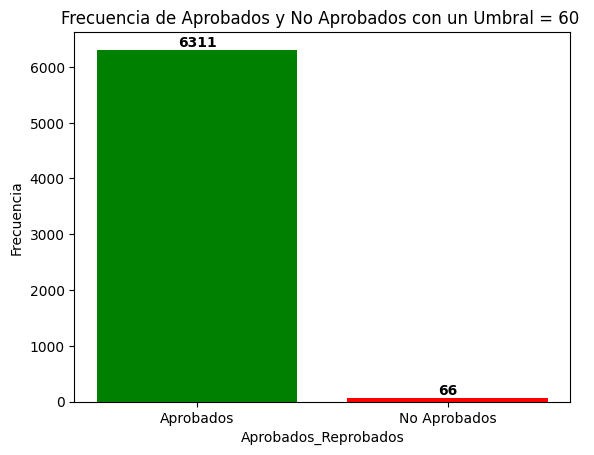

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 60 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

El umbral de 60 genera un dataset muy desequilibrado, con una gran diferencia entre la cantidad de aprobados (6311) y no aprobados (66). Este desequilibrio provoca que el modelo se vuelva sesgado, ya que al existir muchos más casos de aprobados, tenderá a predecir casi siempre esta categoría para obtener una alta precisión. Sin embargo, aunque la exactitud (accuracy) pueda resultar con valores muy buenos, el modelo no será realmente capaz de identificar correctamente a los estudiantes no aprobados, generando resultados engañosos. Además, este desbalance dificulta el proceso de aprendizaje, ya que el modelo dispone de muy poca información sobre los casos minoritarios, lo que limita su capacidad para distinguir entre ambas clases. Es por eso que el desequilibrio generado por el umbral de 60 afecta negativamente el rendimiento del modelo y puede producir sesgos hacia la clase mayoritaria.


In [ ]:
# @title Función de clasificación
def flujo_clasificacion(modelo, param_grid, X_train, X_test, y_train, y_test):

  # Validación cruzada
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # Tuning con grid_search
  grid = GridSearchCV(
      estimator=modelo,
      param_grid=param_grid,
      cv=cv,
      scoring='balanced_accuracy',
      n_jobs=-1,
      return_train_score=True
  )

  # Entrenamiento del GridSearch
  grid.fit(X_train, y_train)

  # Obtención del mejor modelo
  mejor_modelo = grid.best_estimator_

  # Metricas de cada fold del mejor modelo
  scores_folds = cross_val_score(
      mejor_modelo, X_train, y_train,
      cv=cv,
      scoring=make_scorer(balanced_accuracy_score)
  )

  # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
  mejor_modelo.fit(X_train, y_train)
  y_pred = mejor_modelo.predict(X_test)

  balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
  mcc_final = matthews_corrcoef(y_test, y_pred)

  # Importancia de columnas
  try: # manejo de error para el SVC
    importantes = pd.DataFrame({
        'Columna': X_train.columns,
        'Importancia': mejor_modelo.feature_importances_
    })
  except AttributeError:
    importantes = None
    print("El modelo no tiene un atributo 'feature_importances_'.")

  # Calcular matriz de confusión
  cm = confusion_matrix(y_test, y_pred)

  return grid, scores_folds, balanced_acc_final, mcc_final, classification_report(y_test, y_pred, zero_division=0), cm, importantes

In [ ]:
#@title Primera partición de dataset para evaluar y evitar sobre entrenamiento
X = df_60.drop(['Exam_Score','Aprobados'], axis=1)
y = df_60['Aprobados']

# Partición inicial Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

Se realiza una partición del dataset en un 80% para entrenamiento (Train) y un 20% para prueba (Test) con el objetivo de evaluar correctamente el rendimiento del modelo y evitar el sobreajuste. El conjunto de entrenamiento se utiliza para que el modelo aprenda los patrones de los datos, mientras que el conjunto de prueba sirve para comprobar su capacidad de generalización con información que no ha visto antes. Además, se aplica la opción stratify para mantener las proporciones de aprobados y no aprobados, garantizando una representación equilibrada de las clases en ambas particiones.

## **Gaussian Bayes**

In [ ]:
# Modelo base
model = GaussianNB()

# Validación cruzada con StratifiedKFold SOLO CON ENTRENAMIENTOS
# Con 5 splits de organizacion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Obtencion de los resultados de la validación cruzada con metricas puntuales
scores_folds = cross_val_score(
    model, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score)
)

# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del modelo:
Fold 1: 0.7248
Fold 2: 0.5990
Fold 3: 0.6480
Fold 4: 0.8167
Fold 5: 0.7258

Promedio: 0.7029 | Desviación estándar: 0.0745


In [ ]:
 # Entrenamiento del modelo fina con todo el x_train y evaluar con el test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

balanced_acc_final = balanced_accuracy_score(y_test, y_pred)
mcc_final = matthews_corrcoef(y_test, y_pred)

# Evaluacion final
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Evaluación final:
Balanced Accuracy: 0.73
Matthews Corrcoef: 0.5852

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.46      0.57        13
        True       0.99      1.00      1.00      1263

    accuracy                           0.99      1276
   macro avg       0.87      0.73      0.78      1276
weighted avg       0.99      0.99      0.99      1276



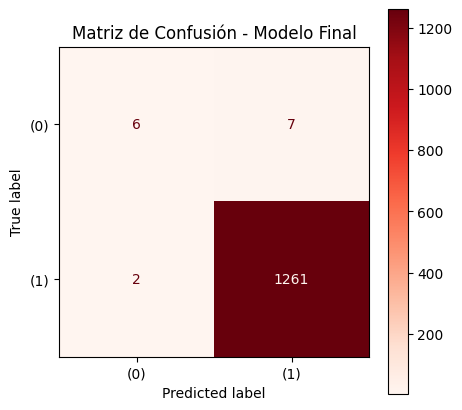

In [ ]:
# Creacion de la matriz de confusión

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Decision Tree**

In [ ]:
# Modelo base
tree = DecisionTreeClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10, 20, 30, 50, 100, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 20}
Mejor balanced accuracy promedio: 0.733923018664602


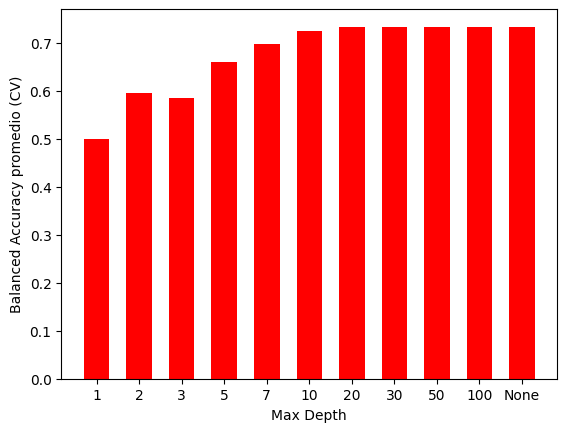

In [ ]:
# Gráfica de los hiperparametros
results = grid.cv_results_
depths = [str(d) if d is not None else "None" for d in param_grid['max_depth']]
scores = results['mean_test_score']

plt.bar(depths, scores, color='red', width= 0.6)
plt.xlabel('Max Depth')
plt.ylabel('Balanced Accuracy promedio (CV)')
plt.show()

In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.7678
Fold 2: 0.6955
Fold 3: 0.8950
Fold 4: 0.6769
Fold 5: 0.6344

Promedio: 0.7339 | Desviación estándar: 0.0914


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.613
Matthews Corrcoef: 0.2712

Classification Report:
              precision    recall  f1-score   support

       False       0.33      0.23      0.27        13
        True       0.99      1.00      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.66      0.61      0.63      1276
weighted avg       0.99      0.99      0.99      1276



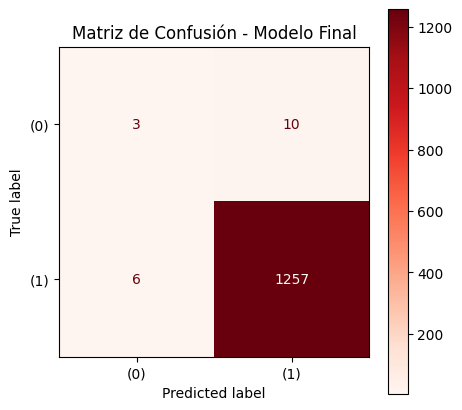

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

###**¿Todas mis columnas son importantes?**

In [ ]:
display(importantes.sort_values(by='Importancia', ascending=False))

,Columna,Importancia
0,Hours_Studied,0.203607
1,Attendance,0.193117
4,Sleep_Hours,0.084442
3,Access_to_Resources,0.072671
7,Tutoring_Sessions,0.063447
5,Previous_Scores,0.056633
9,Teacher_Quality,0.054974
11,Physical_Activity,0.054903
17,Learning_Disabilities_Yes,0.044634
6,Motivation_Level,0.041976


In [ ]:
# Rango ajustable
min_importancia = 0.01 # valor mínimo

# Filtrado las columnas dentro del rango
features_filtradas = importantes[
    (importantes["Importancia"] >= min_importancia)
]["Columna"]

# Filtrado el dataset original X
X_filtrado = X[features_filtradas]

display(X_filtrado.head())


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Sleep_Hours,Previous_Scores,Motivation_Level,Tutoring_Sessions,Family_Income,Teacher_Quality,Physical_Activity,Parental_Education_Level,Distance_from_Home,School_Type_Public,Learning_Disabilities_Yes
0,23,84,1,3,7,73,1,0,1,2,3,1,1,1,0
1,19,64,1,2,8,59,1,2,2,2,4,2,2,1,0
2,24,98,2,2,7,91,2,2,2,2,4,3,1,1,0
3,29,89,1,2,8,98,2,1,2,2,4,1,2,1,0
4,19,92,2,2,6,65,2,3,2,3,4,2,1,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y,
    test_size=0.2,       # 80 train - 20 test
    stratify=y,          # mantiene proporciones del desbalance
    random_state=42
)

In [ ]:
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(tree, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.6126
Matthews Corrcoef: 0.2565

Classification Report:
              precision    recall  f1-score   support

       False       0.30      0.23      0.26        13
        True       0.99      0.99      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.65      0.61      0.63      1276
weighted avg       0.99      0.99      0.99      1276



## **Random Forest**

In [ ]:
# Modelo base
forest = RandomForestClassifier(random_state=42)

# Espacio de hiperparámetros para el tuning
param_grid = {
    'n_estimators': [2, 5, 10, 50, 100], # numero de arboles a realizar
    'max_depth': [2, 3, 5, 10, 15, 20, None]
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(forest, param_grid, X_train, X_test, y_train, y_test)

In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'max_depth': 15, 'n_estimators': 2}
Mejor balanced accuracy promedio: 0.690474103901966


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.7179
Fold 2: 0.6431
Fold 3: 0.7881
Fold 4: 0.5850
Fold 5: 0.7184

Promedio: 0.6905 | Desviación estándar: 0.0699


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.6043
Matthews Corrcoef: 0.1361

Classification Report:
              precision    recall  f1-score   support

       False       0.10      0.23      0.14        13
        True       0.99      0.98      0.98      1263

    accuracy                           0.97      1276
   macro avg       0.54      0.60      0.56      1276
weighted avg       0.98      0.97      0.98      1276



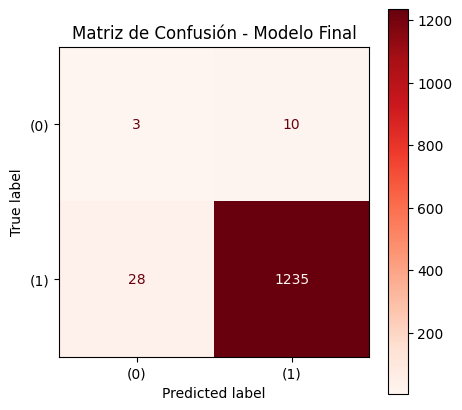

In [ ]:
# Creacion de la matriz de confusión
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["(0)", "(1)"]
)

# Graficar
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(
    cmap="Reds",
    values_format="d",
    ax=ax
)
plt.title("Matriz de Confusión - Modelo Final")
plt.show()

## **Support Vector Machine** -- EN REVISIÓN

In [ ]:
# Modelo base
svc = SVC()

# Definición del grid de hiperparámetros
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],  # los kernels que queremos probar
}

In [ ]:
# Llamado de la función
grid, scores_folds, balanced_acc_final, mcc_final, report, cm, importantes = flujo_clasificacion(svc, param_grid, X_train, X_test, y_train, y_test)

El modelo no tiene un atributo 'feature_importances_'.


In [ ]:
# Mejores hiperparametros
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor balanced accuracy promedio:", grid.best_score_)

Mejores hiperparámetros: {'kernel': 'rbf'}
Mejor balanced accuracy promedio: 0.5


In [ ]:
# Balanced accuracy de cada fold del mejor modelo encontrado
print("Balanced Accuracy en cada fold del mejor modelo:")
for i, score in enumerate(scores_folds, start=1):
    print(f"Fold {i}: {score:.4f}")

print("\nPromedio:", scores_folds.mean().round(4), "| Desviación estándar:", scores_folds.std().round(4))

Balanced Accuracy en cada fold del mejor modelo:
Fold 1: 0.5000
Fold 2: 0.5000
Fold 3: 0.5000
Fold 4: 0.5000
Fold 5: 0.5000

Promedio: 0.5 | Desviación estándar: 0.0


In [ ]:
# Evaluacion final del mejor modelo
print("Evaluación final:")
print("Balanced Accuracy:", round(balanced_acc_final, 4))
print("Matthews Corrcoef:", round(mcc_final, 4))
print("\nClassification Report:")
print(report)

Evaluación final:
Balanced Accuracy: 0.5
Matthews Corrcoef: 0.0

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        13
        True       0.99      1.00      0.99      1263

    accuracy                           0.99      1276
   macro avg       0.49      0.50      0.50      1276
weighted avg       0.98      0.99      0.98      1276



# **Umbral de aprobados por puntaje mayor igual a *67***


---


In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 67

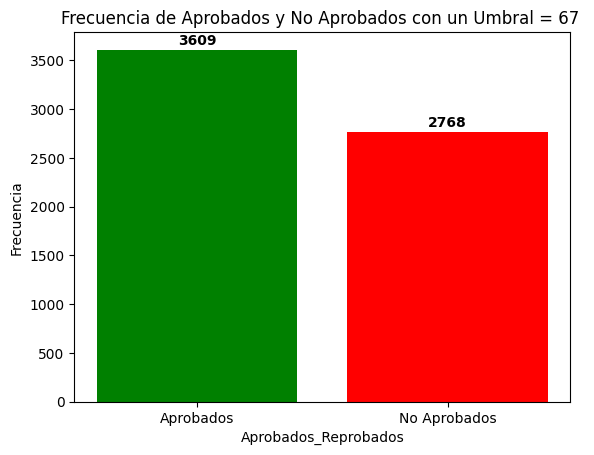

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 67 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

## **Gaussian Bayes**

## **Decision Tree**

## **Random Forest**

## **Support Vector Machine**

# **Umbral de aprobados por puntaje mayor igual a *70***

---

In [ ]:
# Preparacion de del dataset

# copia del DataFrame
df_60 = df_encoded.copy()

# Agregar la columna booleana de aprobados si tiene valor mayor igual a 70
df_60['Aprobados'] = df_60['Exam_Score'] >= 70

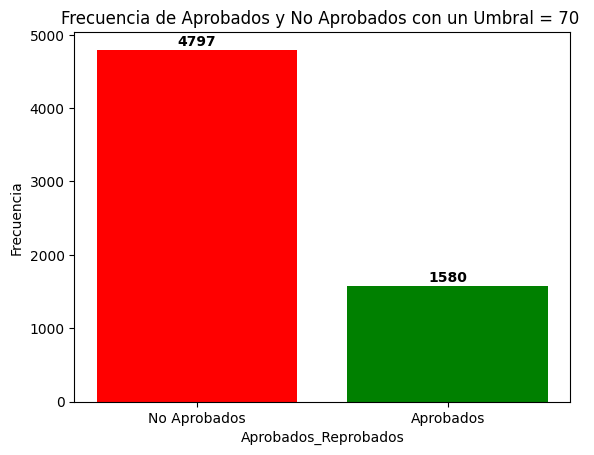

In [ ]:
# @title Visualización de datos por categoría

# Frecuencias por categoría
categorias = df_60['Aprobados'].value_counts()

# Colores para True y False
colores = ['green' if valor else 'red' for valor in categorias.index]

etiquetas = ['Aprobados' if valor else 'No Aprobados' for valor in categorias.index]
plt.bar(etiquetas, categorias.values, color=colores)

# Añadir los valores encima de cada barra
for i, v in enumerate(categorias.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')  # el +50 es para que no se superponga

# Títulos y etiquetas
plt.title('Frecuencia de Aprobados y No Aprobados con un Umbral = 70 ')
plt.xlabel('Aprobados_Reprobados')
plt.ylabel('Frecuencia')

plt.show()

## **Gaussian Bayes**

## **Decision Tree**

## **Random Forest**

## **Support Vector Machine**